# Creating an AI app that detects diseases in plants using Facebook’s deep learning platform: PyTorch

# Importing the libraries
First up is importing the packages you'll need. It's good practice to keep all the imports at the beginning of your code. As you work through this notebook and find you need to import a package, make sure to add the import up here. The notebook was made on Google Colab.

In [1]:
# We need pillow version of 5.3.0
# We will uninstall the older version first
!pip uninstall -y Pillow
# Install the new one
!pip install Pillow==5.3.0
# Let's verify the version
# This should print 5.3.0. If it doesn't, then restart your runtime:
# Menu > Runtime > Restart Runtime
!pip install image
!pip3 install http://download.pytorch.org/whl/cu80/torch-0.4.0-cp36-cp36m-linux_x86_64.whl
!pip3 install torchvision
import PIL
print(PIL.PILLOW_VERSION)

Found existing installation: Pillow 7.1.2
Uninstalling Pillow-7.1.2:
  Successfully uninstalled Pillow-7.1.2
     |████████████████████████████████| 2.0 MB 11.7 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bokeh 2.3.3 requires pillow>=7.1.0, but you have pillow 5.3.0 which is incompatible.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


     |████████████████████████████████| 7.9 MB 18.1 MB/s 
  Created wheel for image: filename=image-1.5.33-py2.py3-none-any.whl size=19496 sha256=544cd82a26442e5dced4fa683c26bee80a13ccabcc72e2cd844d9b86ffc26592
  Stored in directory: /root/.cache/pip/wheels/56/88/e6/897194cfe8c08a8b9afd881d3bf53d102e13fa39607d721383
Successfully built image
ERROR: torch-0.4.0-cp36-cp36m-linux_x86_64.whl is not a supported wheel on this platform.
7.1.2


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: DeprecationWarning: PILLOW_VERSION is deprecated and will be removed in a future release. Use __version__ instead.
  del sys.path[0]


In [1]:
# We will verify that GPU is enabled for this notebook
# Following should print: CUDA is available!  Training on GPU ...
# if it prints otherwise, then you need to enable GPU: 
# From Menu > Runtime > Change Runtime Type > Hardware Accelerator > GPU
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch
import time
import numpy as np
from torch import nn, optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
import torchvision
from collections import OrderedDict
from torch.autograd import Variable
from PIL import Image
from torch.optim import lr_scheduler
import copy
import json
import os
from os.path import exists
# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

CUDA is available!  Training on GPU ...
cuda:0


# Load the data

Here you'll use 'torchvision'  to load the data ([documentation](http://pytorch.org/docs/0.3.0/torchvision/index.html)). The dataset is split into two parts, training and validation. For the training, you'll want to apply transformations such as random scaling, cropping, and flipping. This will help the network generalize leading to better performance. If you use a pre-trained network, you'll also need to make sure the input data is resized to 224x224 pixels as required by the networks.

The validation set is used to measure the model's performance on data it hasn't seen yet. For this you don't want any scaling or rotation transformations, but you'll need to resize then crop the images to the appropriate size.

The pre-trained networks available from 'torchvision' were trained on the ImageNet dataset where each color channel was normalized separately. For both sets you'll need to normalize the means and standard deviations of the images to what the network expects. For the means, it's ' [0.485, 0.456, 0.406]'  and for the standard deviations ''[0.229, 0.224, 0.225]' , calculated from the ImageNet images.  These values will shift each color channel to be centered at 0 and range from -1 to 1.

In [2]:
!pip install --upgrade --no-cache-dir gdown
!gdown --id 1cGst2z4B385m9KZa6_8sBTv9DPpUieOd

file_id= "1cGst2z4B385m9KZa6_8sBTv9DPpUieOd"
# Download dataset
!gdown https://drive.google.com/uc?id={file_id}

# Unzip the downloaded file
!unzip -q PlantVillage.zip

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for gdown: filename=gdown-4.4.0-py3-none-any.whl size=14774 sha256=a4dd4a0090cf83b52852115ba9e5fa36e49f43544f5e86abe19d007158cadee4
  Stored in directory: /tmp/pip-ephem-wheel-cache-wqqs3bh5/wheels/fb/c3/0e/c4d8ff8bfcb0461afff199471449f642179b74968c15b7a69c
Successfully built gdown
  Attempting uninstall: gdown
    Found existing installation: gdown 4.2.2
    Uninstalling gdown-4.2.2:
      Successfully uninstalled gdown-4.2.2
/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1cGst2z4B385m9KZa6_8sBTv9DPpUieOd
To: /content/PlantVillage.zip
100% 466M/466M [00:02<00:00, 200MB/s]
Access denied with the following error:

 	Cannot

In [3]:
#Organizing the dataset
data_dir = '/content/PlantVillage'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/val'
nThreads = 4
batch_size = 32
use_gpu = torch.cuda.is_available()

# Label mapping

You'll also need to load in a mapping from category label to category name. You can find this in the file `cat_to_name.json`. It's a JSON object which you can read in with the [`json` module](https://docs.python.org/2/library/json.html). This will give you a dictionary mapping the integer encoded categories to the actual names of the plant diseases.

In [4]:
import json

dir_name = os.listdir(train_dir)
#with open('categories.json', 'r') as f:
#    cat_to_name = json.load(f)
cat_to_name=json.dumps(dir_name)
    

In [5]:
cat_to_name

'["Tomato___Tomato_YellowLeaf__Curl_Virus", "Tomato___Tomato_mosaic_virus", "Tomato___Leaf_Mold", "Tomato___Septoria_leaf_spot", "Tomato___Bacterial_spot", "Tomato___Early_blight", "Tomato___healthy", "Tomato___Target_Spot", "Pepper__bell___healthy", "Tomato___Spider_mites_Two_spotted_spider_mite", "Potato___Early_blight", "Tomato___Late_blight", "Pepper__bell___Bacterial_spot", "Potato___healthy", "Potato___Late_blight"]'

In [9]:
# Define your transforms for the training and validation sets
# Data augmentation and normalization for training
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomRotation(30),
        transforms.RandomResizedCrop(224),
        #transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# Load the datasets with ImageFolder

data_dir = 'PlantVillage'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}

# Using the image datasets and the trainforms, define the dataloaders
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}

class_names = image_datasets['train'].classes

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


# Building and training the classifier

Now that the data is ready, it's time to build and train the classifier. As usual, you should use one of the pretrained models from `torchvision.models` to get the image features. Build and train a new feed-forward classifier using those features. Resnet-152 pretrained model is used for this image classifier.

In [10]:
# Build and train your network

# 1. Load resnet-152 pre-trained network
model = models.resnet152(pretrained=True)
# Freeze parameters so we don't backprop through them

for param in model.parameters():
    param.requires_grad = False

#Let's check the model architecture:
    print(model)

Downloading: "https://download.pytorch.org/models/resnet152-394f9c45.pth" to /root/.cache/torch/hub/checkpoints/resnet152-394f9c45.pth


  0%|          | 0.00/230M [00:00<?, ?B/s]

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [11]:
# 2. Define a new, untrained feed-forward network as a classifier, using ReLU activations

# Our input_size matches the in_features of pretrained model


from collections import OrderedDict


# Creating the classifier ordered dictionary first

classifier = nn.Sequential(OrderedDict([
                          ('fc1', nn.Linear(2048, 512)),
                          ('relu', nn.ReLU()),
                          ('fc2', nn.Linear(512, 39)),
                          ('output', nn.LogSoftmax(dim=1))
                          ]))

# Replacing the pretrained model classifier with our classifier
model.fc = classifier

In [12]:
#Function to train the model
def train_model(model, criterion, optimizer, scheduler, num_epochs=20):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(1, num_epochs+1):
        print('Epoch {}/{}'.format(epoch, num_epochs))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs, labels = inputs.to(device), labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best valid accuracy: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [13]:
# Train a model with a pre-trained network
num_epochs = 10
if use_gpu:
    print ("Using GPU: "+ str(use_gpu))
    model = model.cuda()

# NLLLoss because our output is LogSoftmax
criterion = nn.NLLLoss()

# Adam optimizer with a learning rate
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)
# Decay LR by a factor of 0.1 every 5 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)


model_ft = train_model(model, criterion, optimizer, exp_lr_scheduler, num_epochs=10)

Using GPU: True
Epoch 1/10
----------


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_che

train Loss: 0.8106 Acc: 0.7460
val Loss: 0.8130 Acc: 0.7824

Epoch 2/10
----------
train Loss: 0.5432 Acc: 0.8202
val Loss: 0.7872 Acc: 0.8049

Epoch 3/10
----------
train Loss: 0.4667 Acc: 0.8451
val Loss: 0.8929 Acc: 0.7953

Epoch 4/10
----------
train Loss: 0.4272 Acc: 0.8572
val Loss: 0.6850 Acc: 0.8517

Epoch 5/10
----------
train Loss: 0.3281 Acc: 0.8893
val Loss: 0.6478 Acc: 0.8649

Epoch 6/10
----------
train Loss: 0.3218 Acc: 0.8922
val Loss: 0.6829 Acc: 0.8603

Epoch 7/10
----------
train Loss: 0.3088 Acc: 0.8957
val Loss: 0.6712 Acc: 0.8566

Epoch 8/10
----------
train Loss: 0.3003 Acc: 0.8995
val Loss: 0.7051 Acc: 0.8604

Epoch 9/10
----------
train Loss: 0.3002 Acc: 0.9001
val Loss: 0.6733 Acc: 0.8610

Epoch 10/10
----------
train Loss: 0.2872 Acc: 0.9048
val Loss: 0.6968 Acc: 0.8557

Training complete in 75m 20s
Best valid accuracy: 0.864873


In [14]:
# Do validation on the test set
def test(model, dataloaders, device):
  model.eval()
  accuracy = 0
  
  model.to(device)
    
  for images, labels in dataloaders['val']:
    images = Variable(images)
    labels = Variable(labels)
    images, labels = images.to(device), labels.to(device)
      
    output = model.forward(images)
    ps = torch.exp(output)
    equality = (labels.data == ps.max(1)[1])
    accuracy += equality.type_as(torch.FloatTensor()).mean()
      
    print("Testing Accuracy: {:.3f}".format(accuracy/len(dataloaders['val'])))



In [15]:
test(model, dataloaders, device)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Testing Accuracy: 0.003
Testing Accuracy: 0.007
Testing Accuracy: 0.012
Testing Accuracy: 0.015
Testing Accuracy: 0.019
Testing Accuracy: 0.023
Testing Accuracy: 0.027
Testing Accuracy: 0.031
Testing Accuracy: 0.036
Testing Accuracy: 0.040
Testing Accuracy: 0.043
Testing Accuracy: 0.047
Testing Accuracy: 0.051
Testing Accuracy: 0.055
Testing Accuracy: 0.059
Testing Accuracy: 0.063
Testing Accuracy: 0.067
Testing Accuracy: 0.071
Testing Accuracy: 0.075
Testing Accuracy: 0.079
Testing Accuracy: 0.083
Testing Accuracy: 0.087
Testing Accuracy: 0.091
Testing Accuracy: 0.095
Testing Accuracy: 0.099
Testing Accuracy: 0.103
Testing Accuracy: 0.107
Testing Accuracy: 0.111
Testing Accuracy: 0.115
Testing Accuracy: 0.119
Testing Accuracy: 0.123
Testing Accuracy: 0.127
Testing Accuracy: 0.131
Testing Accuracy: 0.135
Testing Accuracy: 0.139
Testing Accuracy: 0.143
Testing Accuracy: 0.147
Testing Accuracy: 0.151
Testing Accuracy: 0.155
Testing Accuracy: 0.159
Testing Accuracy: 0.163
Testing Accuracy

# Save the checkpoint

Now that the network is trained,  we will save the model so we can load it later for making predictions. We will save the mapping of classes to indices which we get from one of the image datasets: `image_datasets['train'].class_to_idx`. We will attach this to the model as an attribute which makes inference easier later on.

```model.class_to_idx = image_datasets['train'].class_to_idx```

Remember that we'll want to completely rebuild the model later so we can use it for inference. Make sure to include any information you need in the checkpoint. If you want to load the model and keep training, you'll want to save the number of epochs as well as the optimizer state, `optimizer.state_dict`. You'll likely want to use this trained model in the next part of the project, so best to save it now.

In [62]:
# Save the checkpoint 

model.class_to_idx = dataloaders['train'].dataset.class_to_idx
model.epochs = num_epochs
checkpoint = {'input_size': [3, 224, 224],
                 'batch_size': dataloaders['train'].batch_size,
                  'output_size': 39,
                  'state_dict': model.state_dict(),
                  'data_transforms': data_transforms,
                  'optimizer_dict':optimizer.state_dict(),
                  'class_to_idx': model.class_to_idx,
                  'epoch': model.epochs}
torch.save(checkpoint, '/content/drive/MyDrive/plants9615_checkpoint.hdf5')

In [16]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Loading the checkpoint

At this point it's good to write a function that can load a checkpoint and rebuild the model. That way you can come back to this project and keep working on it without having to retrain the network.

In [ ]:
#Download the trained model from here: 
!gdown https://drive.google.com/uc?id=1D3mWC5AAWlx3OdU4yljt7vtEPrpLFtmZ

Downloading...
From: https://drive.google.com/uc?id=1D3mWC5AAWlx3OdU4yljt7vtEPrpLFtmZ
To: /content/plants9615_checkpoint.pth
246MB [00:02, 102MB/s]


In [63]:
# Write a function that loads a checkpoint and rebuilds the model

def load_checkpoint(filepath):
    checkpoint = torch.load(filepath)
    model = models.resnet152()
    
    # Our input_size matches the in_features of pretrained model
    input_size = 2048
    output_size = 39
    
    classifier = nn.Sequential(OrderedDict([
                          ('fc1', nn.Linear(2048, 512)),
                          ('relu', nn.ReLU()),
                          #('dropout1', nn.Dropout(p=0.2)),
                          ('fc2', nn.Linear(512, 39)),
                          ('output', nn.LogSoftmax(dim=1))
                          ]))

# Replacing the pretrained model classifier with our classifier
    model.fc = classifier
    
    
    model.load_state_dict(checkpoint['state_dict'])
    
    return model, checkpoint['class_to_idx']

# Get index to class mapping
loaded_model, class_to_idx = load_checkpoint('/content/drive/MyDrive/plants9615_checkpoint.hdf5')
idx_to_class = { v : k for k,v in class_to_idx.items()}

# Inference for classification

Now you'll write a function to use a trained network for inference. That is, you'll pass an image into the network and predict the class of the plant disease in the image. Write a function called `predict` that takes an image and a model, then returns the top $K$ most likely classes along with the probabilities. It should look like 


In [64]:
def process_image(image):
    ''' Scales, crops, and normalizes a PIL image for a PyTorch model,
        returns an Numpy array
    '''
    
    # Process a PIL image for use in a PyTorch model

    size = 256, 256
    image.thumbnail(size, Image.ANTIALIAS)
    image = image.crop((128 - 112, 128 - 112, 128 + 112, 128 + 112))
    npImage = np.array(image)
    npImage = npImage/255.
        
    imgA = npImage[:,:,0]
    imgB = npImage[:,:,1]
    imgC = npImage[:,:,2]
    
    imgA = (imgA - 0.485)/(0.229) 
    imgB = (imgB - 0.456)/(0.224)
    imgC = (imgC - 0.406)/(0.225)
        
    npImage[:,:,0] = imgA
    npImage[:,:,1] = imgB
    npImage[:,:,2] = imgC
    
    npImage = np.transpose(npImage, (2,0,1))
    
    return npImage

In [65]:
def imshow(image, ax=None, title=None):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    
    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    image = image.numpy().transpose((1, 2, 0))
    
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    
    return ax

# Class Prediction

Once you can get images in the correct format, it's time to write a function for making predictions with your model. A common practice is to predict the top 5 or so (usually called top-$K$) most probable classes. You'll want to calculate the class probabilities then find the $K$ largest values.

To get the top $K$ largest values in a tensor use [`x.topk(k)`](http://pytorch.org/docs/master/torch.html#torch.topk). This method returns both the highest `k` probabilities and the indices of those probabilities corresponding to the classes. You need to convert from these indices to the actual class labels using `class_to_idx` which hopefully you added to the model or from an `ImageFolder` you used to load the data ([see here](#Save-the-checkpoint)). Make sure to invert the dictionary so you get a mapping from index to class as well.

Again, this method should take a path to an image and a model checkpoint, then return the probabilities and classes.

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']

In [66]:
def predict(image_path, model, topk=5):
    ''' Predict the class (or classes) of an image using a trained deep learning model.
    '''
    
    # Implement the code to predict the class from an image file
    
    image = torch.FloatTensor([process_image(Image.open(image_path))])
    model.eval()
    output = model.forward(Variable(image))
    pobabilities = torch.exp(output).data.numpy()[0]
    

    top_idx = np.argsort(pobabilities)[-topk:][::-1] 
    top_class = [idx_to_class[x] for x in top_idx]
    top_probability = pobabilities[top_idx]

    return top_probability, top_class

In [67]:
print (predict('/content/PlantVillage/val/Potato___Late_blight/0085ef03-aec3-431a-99a1-de286e10c0cf___RS_LB 2949_180deg.JPG', loaded_model))

(array([9.6211088e-01, 3.2758120e-02, 2.3761641e-03, 1.7920875e-03,
       8.4884715e-04], dtype=float32), ['Potato___Late_blight', 'Tomato___Late_blight', 'Tomato___Target_Spot', 'Tomato___Early_blight', 'Potato___healthy'])


# Sanity Checking

Now that you can use a trained model for predictions, check to make sure it makes sense. Even if the validation accuracy is high, it's always good to check that there aren't obvious bugs. Use `matplotlib` to plot the probabilities for the top 5 classes as a bar graph, along with the input image. It should look like this:

You can convert from the class integer encoding to actual plant diseases names with the `cat_to_name.json` file (should have been loaded earlier in the notebook). To show a PyTorch tensor as an image, use the `imshow` function defined above.

In [60]:
# Display an image along with the top 5 classes
def view_classify(img, probabilities, classes, mapper):
    ''' Function for viewing an image and it's predicted classes.
    '''
    img_filename = img.split('/')[-2]
    print("img filename:", img_filename)
    img = Image.open(img)

    print("img",img)

    fig, (ax1, ax2) = plt.subplots(figsize=(6,10), ncols=1, nrows=2)
    flower_name = mapper[img_filename]

    print("flower_name",flower_name)
    
    ax1.set_title(flower_name)
    ax1.imshow(img)
    ax1.axis('off')
    
    y_pos = np.arange(len(probabilities))
    ax2.barh(y_pos, probabilities)
    ax2.set_yticks(y_pos)
    ax2.set_yticklabels([mapper[x] for x in classes])
    ax2.invert_yaxis()

img filename: Potato___Late_blight
img <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=256x256 at 0x7F9A9E46ECD0>


TypeError: ignored

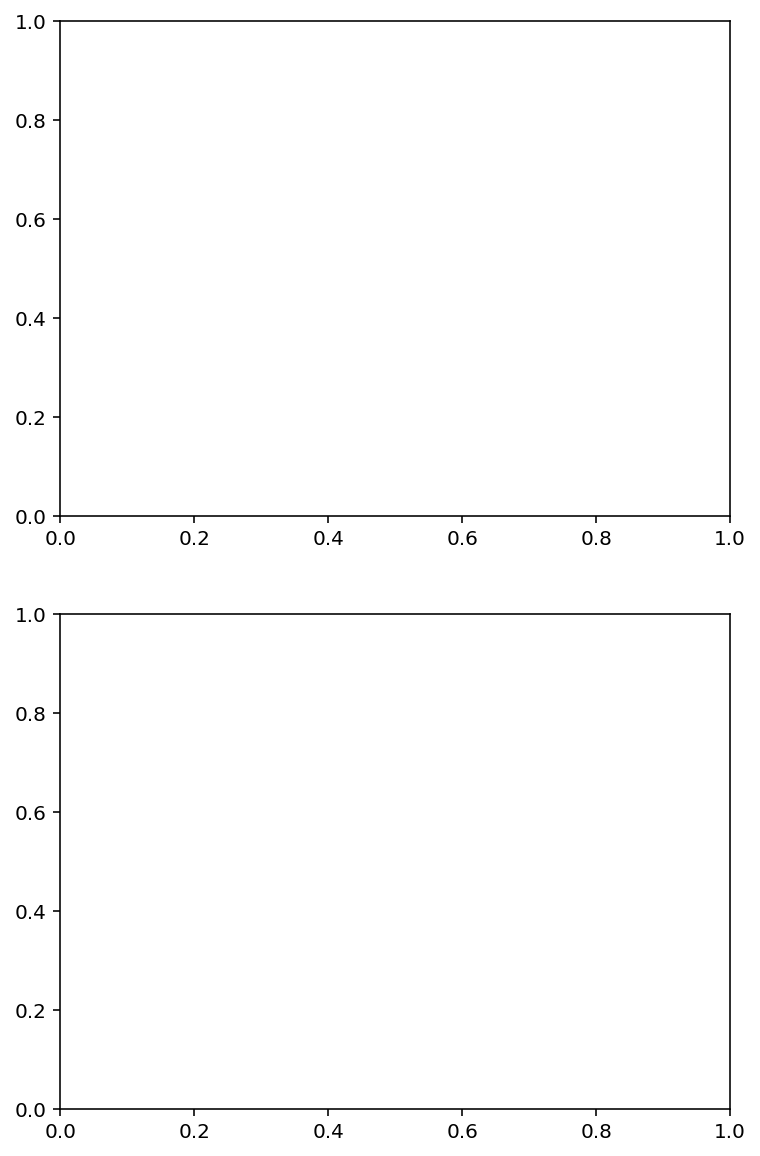

In [61]:
#img = 'PlantVillage/val/Apple___Black_rot/0139bc6d-391c-4fd1-bcae-cc74dabfddd7___JR_FrgE.S 2734.JPG'
#img = 'PlantVillage/val/Tomato___Bacterial_spot/00728f4d-83a0-49f1-87f8-374646fcda05___GCREC_Bact.Sp 6326.JPG'
img = '/content/PlantVillage/val/Potato___Late_blight/01270f5c-a44b-4da7-9398-289088c197ab___RS_LB 2517_flipTB.JPG'
#img = 'PlantVillage/val/Apple___healthy/3af9dc00-a64b-4b45-a034-1d190e5277ea___RS_HL 7788.JPG'
#img = 'PlantVillage/val/Potato___Late_blight/0acdc2b2-0dde-4073-8542-6fca275ab974___RS_LB 4857.JPG'
#img = 'PlantVillage/val/Tomato___Tomato_Yellow_Leaf_Curl_Virus/0e1fda76-d958-490f-9fcb-21e86c99dbe6___UF.GRC_YLCV_Lab 02200.JPG'

p, c = predict(img, loaded_model)
view_classify(img, p, c, cat_to_name)

In [41]:
img = '/content/PlantVillage/val/Pepper__bell___healthy/00100ffa-095e-4881-aebf-61fe5af7226e___JR_HL 7886.JPG'
p, c = predict(img, loaded_model)
view_classify(img, p, c, cat_to_name)

TypeError: ignored

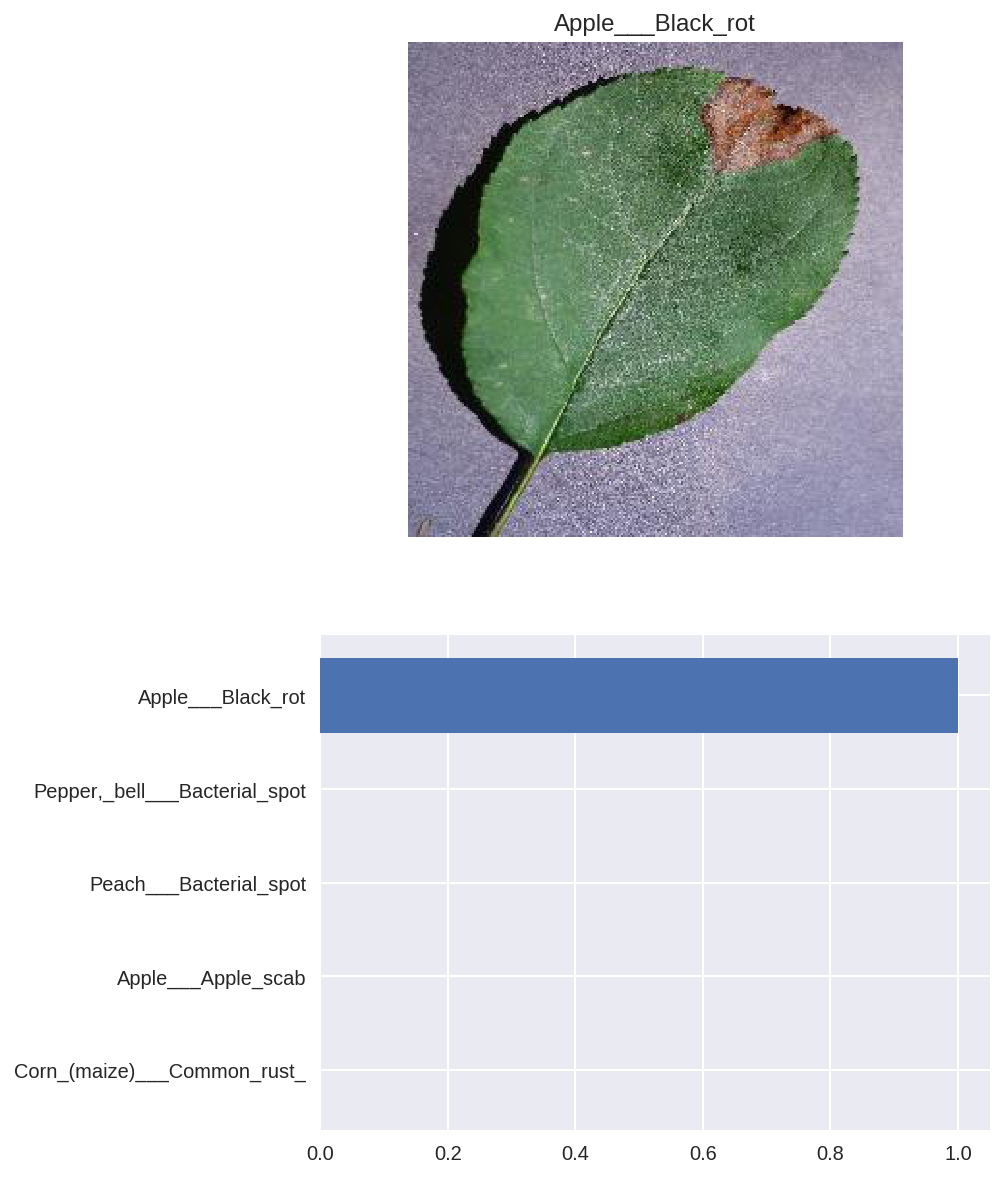

In [ ]:
img = 'PlantVillage/val/Apple___Black_rot/0139bc6d-391c-4fd1-bcae-cc74dabfddd7___JR_FrgE.S 2734.JPG'
p, c = predict(img, loaded_model)
view_classify(img, p, c, cat_to_name)

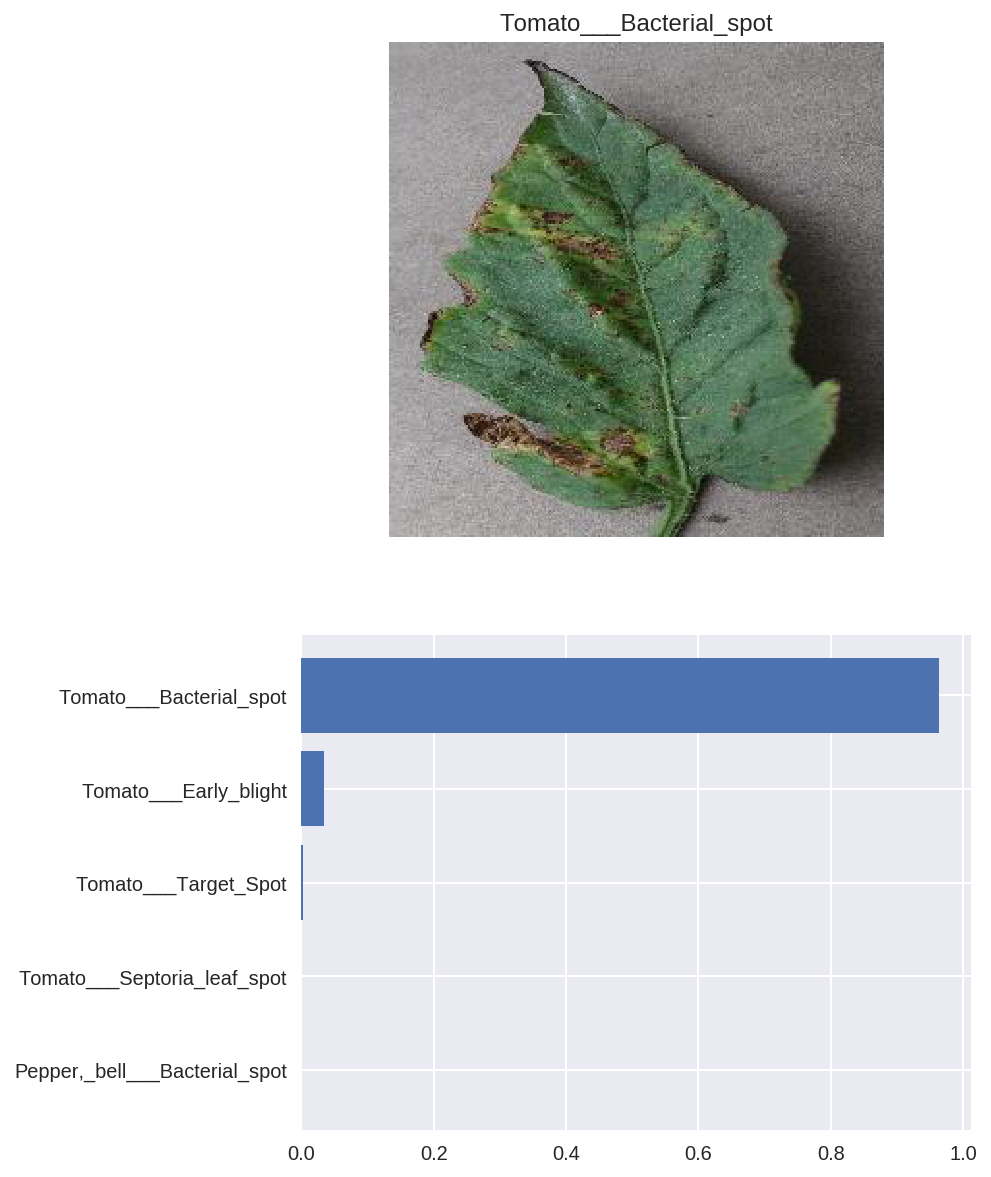

In [ ]:
img = 'PlantVillage/val/Tomato___Bacterial_spot/00728f4d-83a0-49f1-87f8-374646fcda05___GCREC_Bact.Sp 6326.JPG'
p, c = predict(img, loaded_model)
view_classify(img, p, c, cat_to_name)

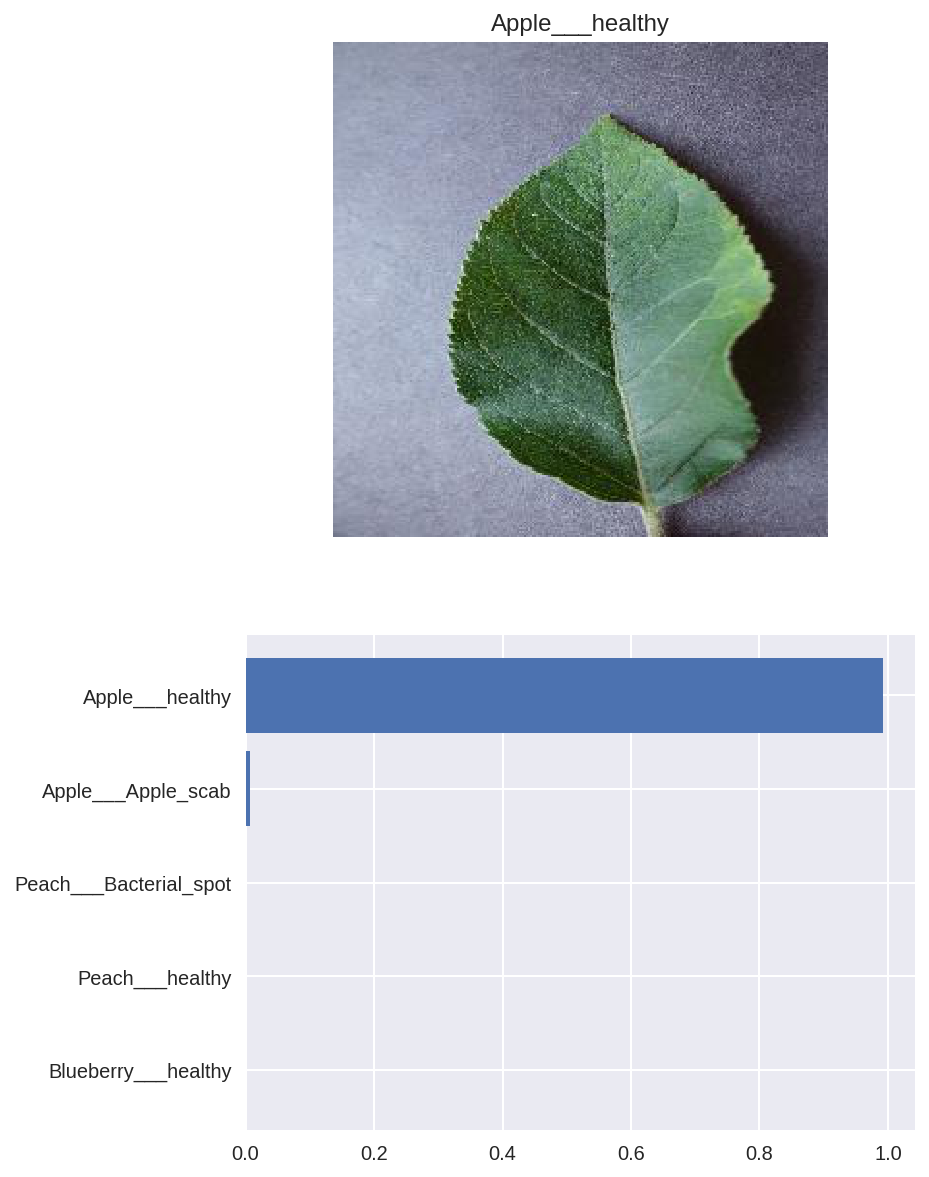

In [ ]:
img = 'PlantVillage/val/Apple___healthy/3af9dc00-a64b-4b45-a034-1d190e5277ea___RS_HL 7788.JPG'
p, c = predict(img, loaded_model)
view_classify(img, p, c, cat_to_name)

# CONCLUSIONS

The model can be improved if you change some hyperparameters. You can try using a different pretrained model. It's up to you. Let me know if you can improve the accuracy!